<a href="https://colab.research.google.com/github/KIMDOKYOUNG/DeepLearning/blob/master/toy_project/toy_project_%EA%B9%80%EB%8F%84%EA%B2%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

NameError: ignored

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 79.8MB/s 
     |████████████████████████████████| 3.8MB 12.5MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import cupy as np

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pickle
import unicodedata
import re
import numpy as np
import os
import io
import time
from matplotlib.font_manager import FontProperties
#from konlpy.tag import Okt
#okt = Okt()

In [3]:
path = './drive/My Drive/Colab Notebooks/datasets/cmn-eng/cmn.txt'

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    #w = unicode_to_ascii(w.lower().strip())
    w = w.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^\u4e00-\u9fff가-힣a-zA-Z?。，.!,¿]+", " ", w) # [\u4e00-\u9fff]

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_chinese(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r'[" "]+', "", w)
    w = w.rstrip().strip()
    w = " ".join(list(w))  # add the space between words
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_examples]]
    print(type(word_pairs))
    word_pairs = [[preprocess_sentence(w[0]), preprocess_chinese(w[1])]
                  for w in word_pairs]
    return zip(*word_pairs)

In [6]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [7]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer= tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer= tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
en,cn = create_dataset(path,3)

<class 'list'>


In [9]:
en

('<start> hi . <end>', '<start> hi . <end>', '<start> run . <end>')

In [10]:
cn

('<start> 嗨 。 <end>', '<start> 你 好 。 <end>', '<start> 你 用 跑 的 。 <end>')

In [11]:
num_examples = 22074
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path, num_examples)


<class 'list'>


In [12]:
len(input_tensor)

22074

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state= 42)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

17659 17659 4415 4415


In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> 你
30 ----> 想
73 ----> 吃
106 ----> 點
279 ----> 東
167 ----> 西
37 ----> 嗎
13 ----> ？
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
78 ----> would
7 ----> you
37 ----> like
6 ----> to
139 ----> eat
131 ----> something
9 ----> ?
2 ----> <end>


In [ ]:
inp_lang

In [75]:
inp_lang.index_word

{1: '<start>',
 2: '<end>',
 3: '。',
 4: '我',
 5: '的',
 6: '了',
 7: '你',
 8: '他',
 9: '不',
 10: '是',
 11: '一',
 12: '在',
 13: '？',
 14: '有',
 15: '姆',
 16: '她',
 17: '，',
 18: '很',
 19: '要',
 20: '這',
 21: '們',
 22: '人',
 23: '汤',
 24: '天',
 25: '这',
 26: '到',
 27: '去',
 28: '個',
 29: '上',
 30: '想',
 31: '们',
 32: '个',
 33: '那',
 34: '好',
 35: '什',
 36: '能',
 37: '嗎',
 38: '子',
 39: '么',
 40: '湯',
 41: '看',
 42: '做',
 43: '得',
 44: '多',
 45: '下',
 46: '麼',
 47: '會',
 48: '吗',
 49: '道',
 50: '生',
 51: '裡',
 52: '可',
 53: '知',
 54: '來',
 55: '以',
 56: '都',
 57: '会',
 58: '喜',
 59: '来',
 60: '没',
 61: '家',
 62: '大',
 63: '把',
 64: '事',
 65: '沒',
 66: '就',
 67: '起',
 68: '说',
 69: '作',
 70: '為',
 71: '时',
 72: '?',
 73: '吃',
 74: '和',
 75: '本',
 76: '为',
 77: '里',
 78: '說',
 79: '打',
 80: '車',
 81: '意',
 82: '時',
 83: '常',
 84: '法',
 85: '出',
 86: '自',
 87: '地',
 88: '給',
 89: '工',
 90: '年',
 91: '明',
 92: '些',
 93: '孩',
 94: '真',
 95: '最',
 96: '晚',
 97: '用',
 98: '開',
 99: '候',
 100: '信'

In [ ]:
input_tensor[-1]

array([   1,    7,   18,  414,  460,   63,  226,  188,   68,   43,  296,
       1470,  478, 3444,   17, 1892,   18,  414,  460,   63,  170,  226,
        188,   68,   43,    9,   86,  292,    3,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [17]:
vocab_inp_size, vocab_tar_size

(3445, 6235)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

In [19]:
vocab_size = len(inp_lang.word_index)+1
wordvec_size = 256
hidden_size = 1024
batch_size = 64
max_epoch = 10
max_grad = 5.0

In [119]:
model = AttentionSeq2seq(vocab_inp_size, vocab_tar_size,wordvec_size, hidden_size)

In [120]:
model.load_params('/content/drive/My Drive/Colab Notebooks/training_checkpoints/cmn-eng/19.pkl')

In [ ]:
model.save_params('5.pkl')

In [ ]:
file_name = '4.pkl'
"/content/drive/My Drive/Colab Notebooks/training_checkpoints/cmn-eng/"+ file_name

'./drive/My Drive/Colab Notebooks/training_checkpoints/cmn-eng/4.pkl'

In [ ]:
def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)
GPU = True

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

| 에폭 1 |  반복 1 / 275 | 시간 10[s] | 손실 8.73
| 에폭 1 |  반복 21 / 275 | 시간 205[s] | 손실 3.55
| 에폭 1 |  반복 41 / 275 | 시간 400[s] | 손실 1.88
| 에폭 1 |  반복 61 / 275 | 시간 595[s] | 손실 1.61
| 에폭 1 |  반복 81 / 275 | 시간 792[s] | 손실 1.55
| 에폭 1 |  반복 101 / 275 | 시간 987[s] | 손실 1.41
| 에폭 1 |  반복 121 / 275 | 시간 1181[s] | 손실 1.40
| 에폭 1 |  반복 141 / 275 | 시간 1379[s] | 손실 1.37
| 에폭 1 |  반복 161 / 275 | 시간 1575[s] | 손실 1.34
| 에폭 1 |  반복 181 / 275 | 시간 1771[s] | 손실 1.32
| 에폭 1 |  반복 201 / 275 | 시간 1968[s] | 손실 1.29
| 에폭 1 |  반복 221 / 275 | 시간 2163[s] | 손실 1.28
| 에폭 1 |  반복 241 / 275 | 시간 2358[s] | 손실 1.27
| 에폭 1 |  반복 261 / 275 | 시간 2557[s] | 손실 1.25


NameError: ignored

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(2,max_epoch):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    model.save_params(file_name = str(epoch)+'.pkl')

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

| 에폭 1 |  반복 1 / 275 | 시간 9[s] | 손실 1.14
| 에폭 1 |  반복 21 / 275 | 시간 206[s] | 손실 1.21
| 에폭 1 |  반복 41 / 275 | 시간 401[s] | 손실 1.21
| 에폭 1 |  반복 61 / 275 | 시간 596[s] | 손실 1.18
| 에폭 1 |  반복 81 / 275 | 시간 791[s] | 손실 1.15
| 에폭 1 |  반복 101 / 275 | 시간 986[s] | 손실 1.13
| 에폭 1 |  반복 121 / 275 | 시간 1180[s] | 손실 1.11
| 에폭 1 |  반복 141 / 275 | 시간 1379[s] | 손실 1.11
| 에폭 1 |  반복 161 / 275 | 시간 1574[s] | 손실 1.06
| 에폭 1 |  반복 181 / 275 | 시간 1769[s] | 손실 1.05
| 에폭 1 |  반복 201 / 275 | 시간 1966[s] | 손실 1.03
| 에폭 1 |  반복 221 / 275 | 시간 2161[s] | 손실 1.02
| 에폭 1 |  반복 241 / 275 | 시간 2356[s] | 손실 1.01
| 에폭 1 |  반복 261 / 275 | 시간 2552[s] | 손실 0.99
| 에폭 2 |  반복 1 / 275 | 시간 9[s] | 손실 0.92


KeyboardInterrupt: ignored

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(3,max_epoch):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    model.save_params(file_name = str(epoch)+'.pkl')

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

| 에폭 1 |  반복 1 / 275 | 시간 9[s] | 손실 0.91
| 에폭 1 |  반복 21 / 275 | 시간 205[s] | 손실 0.90
| 에폭 1 |  반복 41 / 275 | 시간 403[s] | 손실 0.91
| 에폭 1 |  반복 61 / 275 | 시간 597[s] | 손실 0.92
| 에폭 1 |  반복 81 / 275 | 시간 792[s] | 손실 0.90
| 에폭 1 |  반복 101 / 275 | 시간 988[s] | 손실 0.91
| 에폭 1 |  반복 121 / 275 | 시간 1183[s] | 손실 0.90
| 에폭 1 |  반복 141 / 275 | 시간 1377[s] | 손실 0.89
| 에폭 1 |  반복 161 / 275 | 시간 1575[s] | 손실 0.89
| 에폭 1 |  반복 181 / 275 | 시간 1772[s] | 손실 0.86
| 에폭 1 |  반복 201 / 275 | 시간 1966[s] | 손실 0.86
| 에폭 1 |  반복 221 / 275 | 시간 2163[s] | 손실 0.84
| 에폭 1 |  반복 241 / 275 | 시간 2359[s] | 손실 0.84
| 에폭 1 |  반복 261 / 275 | 시간 2553[s] | 손실 0.83
| 에폭 2 |  반복 1 / 275 | 시간 11[s] | 손실 0.74
| 에폭 2 |  반복 21 / 275 | 시간 206[s] | 손실 0.71
| 에폭 2 |  반복 41 / 275 | 시간 402[s] | 손실 0.71
| 에폭 2 |  반복 61 / 275 | 시간 597[s] | 손실 0.71
| 에폭 2 |  반복 81 / 275 | 시간 794[s] | 손실 0.69
| 에폭 2 |  반복 101 / 275 | 시간 989[s] | 손실 0.70
| 에폭 2 |  반복 121 / 275 | 시간 1184[s] | 손실 0.71
| 에폭 2 |  반복 141 / 275 | 시간 1381[s] | 손실 0.70
| 에폭 2 |  반복 16

| 에폭 1 |  반복 1 / 275 | 시간 10[s] | 손실 0.61
| 에폭 1 |  반복 21 / 275 | 시간 217[s] | 손실 0.59
| 에폭 1 |  반복 41 / 275 | 시간 425[s] | 손실 0.60
| 에폭 1 |  반복 61 / 275 | 시간 635[s] | 손실 0.59
| 에폭 1 |  반복 81 / 275 | 시간 841[s] | 손실 0.61
| 에폭 1 |  반복 101 / 275 | 시간 1036[s] | 손실 0.61
| 에폭 1 |  반복 121 / 275 | 시간 1226[s] | 손실 0.61
| 에폭 1 |  반복 141 / 275 | 시간 1415[s] | 손실 0.61
| 에폭 1 |  반복 161 / 275 | 시간 1603[s] | 손실 0.60
| 에폭 1 |  반복 181 / 275 | 시간 1791[s] | 손실 0.59
| 에폭 1 |  반복 201 / 275 | 시간 1983[s] | 손실 0.61
| 에폭 1 |  반복 221 / 275 | 시간 2176[s] | 손실 0.58
| 에폭 1 |  반복 241 / 275 | 시간 2365[s] | 손실 0.60
| 에폭 1 |  반복 261 / 275 | 시간 2553[s] | 손실 0.60
| 에폭 2 |  반복 1 / 275 | 시간 9[s] | 손실 0.46
| 에폭 2 |  반복 21 / 275 | 시간 200[s] | 손실 0.42
| 에폭 2 |  반복 41 / 275 | 시간 394[s] | 손실 0.41
| 에폭 2 |  반복 61 / 275 | 시간 585[s] | 손실 0.43
| 에폭 2 |  반복 81 / 275 | 시간 775[s] | 손실 0.43
| 에폭 2 |  반복 101 / 275 | 시간 971[s] | 손실 0.43
| 에폭 2 |  반복 121 / 275 | 시간 1167[s] | 손실 0.47
| 에폭 2 |  반복 141 / 275 | 시간 1366[s] | 손실 0.44
| 에폭 2 |  반복 1

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

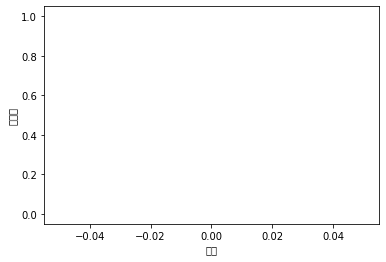

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(5,max_epoch):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    model.save_params(file_name = str(epoch)+'.pkl')

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(10,max_epoch+15):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    model.save_params(file_name = str(epoch)+'.pkl')

| 에폭 1 |  반복 1 / 275 | 시간 10[s] | 손실 0.12
| 에폭 1 |  반복 21 / 275 | 시간 217[s] | 손실 0.14
| 에폭 1 |  반복 41 / 275 | 시간 424[s] | 손실 0.14
| 에폭 1 |  반복 61 / 275 | 시간 629[s] | 손실 0.15
| 에폭 1 |  반복 81 / 275 | 시간 831[s] | 손실 0.14
| 에폭 1 |  반복 101 / 275 | 시간 1029[s] | 손실 0.16
| 에폭 1 |  반복 121 / 275 | 시간 1223[s] | 손실 0.15
| 에폭 1 |  반복 141 / 275 | 시간 1415[s] | 손실 0.16
| 에폭 1 |  반복 161 / 275 | 시간 1604[s] | 손실 0.16
| 에폭 1 |  반복 181 / 275 | 시간 1795[s] | 손실 0.17
| 에폭 1 |  반복 201 / 275 | 시간 1993[s] | 손실 0.17
| 에폭 1 |  반복 221 / 275 | 시간 2198[s] | 손실 0.17
| 에폭 1 |  반복 241 / 275 | 시간 2404[s] | 손실 0.17
| 에폭 1 |  반복 261 / 275 | 시간 2613[s] | 손실 0.17
| 에폭 2 |  반복 1 / 275 | 시간 10[s] | 손실 0.09
| 에폭 2 |  반복 21 / 275 | 시간 211[s] | 손실 0.10
| 에폭 2 |  반복 41 / 275 | 시간 407[s] | 손실 0.10
| 에폭 2 |  반복 61 / 275 | 시간 600[s] | 손실 0.11
| 에폭 2 |  반복 81 / 275 | 시간 792[s] | 손실 0.11
| 에폭 2 |  반복 101 / 275 | 시간 980[s] | 손실 0.11
| 에폭 2 |  반복 121 / 275 | 시간 1170[s] | 손실 0.12
| 에폭 2 |  반복 141 / 275 | 시간 1360[s] | 손실 0.12
| 에폭 2 |  반복 

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(17,max_epoch+10):
    trainer.fit(input_tensor_train, target_tensor_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    model.save_params(file_name = str(epoch)+'.pkl')

| 에폭 1 |  반복 1 / 275 | 시간 10[s] | 손실 0.05
| 에폭 1 |  반복 21 / 275 | 시간 200[s] | 손실 0.05
| 에폭 1 |  반복 41 / 275 | 시간 394[s] | 손실 0.05
| 에폭 1 |  반복 61 / 275 | 시간 588[s] | 손실 0.05
| 에폭 1 |  반복 81 / 275 | 시간 781[s] | 손실 0.05
| 에폭 1 |  반복 101 / 275 | 시간 973[s] | 손실 0.05
| 에폭 1 |  반복 121 / 275 | 시간 1165[s] | 손실 0.05
| 에폭 1 |  반복 141 / 275 | 시간 1356[s] | 손실 0.06
| 에폭 1 |  반복 161 / 275 | 시간 1547[s] | 손실 0.06
| 에폭 1 |  반복 181 / 275 | 시간 1740[s] | 손실 0.06
| 에폭 1 |  반복 201 / 275 | 시간 1931[s] | 손실 0.06
| 에폭 1 |  반복 221 / 275 | 시간 2123[s] | 손실 0.06
| 에폭 1 |  반복 241 / 275 | 시간 2313[s] | 손실 0.06
| 에폭 1 |  반복 261 / 275 | 시간 2505[s] | 손실 0.07
| 에폭 2 |  반복 1 / 275 | 시간 9[s] | 손실 0.04
| 에폭 2 |  반복 21 / 275 | 시간 201[s] | 손실 0.04
| 에폭 2 |  반복 41 / 275 | 시간 393[s] | 손실 0.04
| 에폭 2 |  반복 61 / 275 | 시간 584[s] | 손실 0.05
| 에폭 2 |  반복 81 / 275 | 시간 775[s] | 손실 0.05
| 에폭 2 |  반복 101 / 275 | 시간 966[s] | 손실 0.05
| 에폭 2 |  반복 121 / 275 | 시간 1158[s] | 손실 0.05
| 에폭 2 |  반복 141 / 275 | 시간 1349[s] | 손실 0.05
| 에폭 2 |  반복 16

KeyError: ignored

In [ ]:
correct_num = 0
for i in range(len(input_tensor_val)):
    question, correct = input_tensor_val[[i]], target_tensor_val[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct,inp_lang.index_word, verbose, is_reverse=True)
acc = float(correct_num) / len(input_tensor_val)
acc_list.append(acc)
print('정확도 %.3f%%' % (acc * 100))

KeyError: ignored

In [123]:
question = input_tensor_val[[4]]
question

array([[  1,  16, 271, 722, 569,   5,  71,  99,  59,  26, 390, 529,   3,
          2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [124]:
correct = target_tensor_val[[4]]
correct

array([[  1,  19, 197,   6, 522,  36,   5, 571,  17,   3,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int32)

In [125]:
correct_num = 0
question_list = []
correct_list = []
guess_list = []
for i in range(len(input_tensor_val)):
    question, correct = input_tensor_val[[i]], target_tensor_val[[i]]
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([inp_lang.index_word[c] for c in question.flatten() if c!=0 ])
    correct = ' '.join([targ_lang.index_word[c] for c in correct if c!=0 ])
    guess = ' '.join([targ_lang.index_word[int(c)] for c in guess[2]  if c!=0])
    question_list.append(question)
    correct_list.append(correct)
    guess_list.append(guess)

    print("======",i,"번째=====")
    print("question : ",question)
    print("correct : ",correct)
    print("guess : ", guess)

# acc = float(correct_num) / len(input_tensor_val)
# acc_list.append(acc)
# print('정확도 %.3f%%' % (acc * 100))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
question :  <start>你做了很多。<end>
correct :  you ve done a lot . <end>
guess :  you did a lot of good things . <end>
====== 3166 번째=====
question :  <start>她花了整個下午作飯。<end>
correct :  she spent all afternoon cooking . <end>
guess :  it was hard to work for an hour . <end>
====== 3167 번째=====
question :  <start>湯姆有很多朋友住在波士頓。<end>
correct :  tom has many friends living in boston . <end>
guess :  tom has many friends in common kong . <end>
====== 3168 번째=====
question :  <start>我答应汤姆我会到那里。<end>
correct :  i ve promised tom that i d be there . <end>
guess :  i promised tom to be there . <end>
====== 3169 번째=====
question :  <start>你没什么可抱歉的。<end>
correct :  you have nothing to be sorry about . <end>
guess :  you have nothing to do . <end>
====== 3170 번째=====
question :  <start>即使是小孩也能讀這本書。<end>
correct :  even children can read this book . <end>
guess :  even it is to read a letter to read . <end>
====== 3171 번째=====
question :  <start>波士頓是養小孩的好地方。<end>
corre

In [126]:
len(question_list)

4415

In [127]:
import nltk.translate.bleu_score as bleu


In [142]:
question = question_list[7]
reference = correct_list[7]
candidate = guess_list[7]

print("question : ",question)
print("reference : ",reference)
print("candidate : ",candidate)

print(bleu.sentence_bleu(reference.split(),candidate.split()))

question :  <start>我擅長足球。<end>
reference :  i m good at soccer . <end>
candidate :  i m good at football . <end>
0.8091067115702212


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [144]:
bleu_scores = []
for i in range(len(question_list)):
  reference = correct_list[i]
  candidate = guess_list[i]
  bleu_scores.append(bleu.sentence_bleu(reference.split(),candidate.split()))


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [153]:
np.mean(bleu_scores)

0.649209043383077

In [154]:
np.std(bleu_scores)

0.09628923822446732

In [145]:
len(bleu_scores)

4415

In [161]:
import pandas as pd

In [166]:
df = pd.DataFrame({'question' : question_list,'reference':correct_list,'candidate':guess_list, 'bleu_score':bleu_scores})
df.sort_values(by=['bleu_score'],axis = 0,ascending=False)


,question,reference,candidate,bleu_score
3135,<start>我是個英雄。<end>,i m a hero . <end>,i m a student . <end>,0.903602
2207,<start>吻我。<end>,kiss me . <end>,i m sorry . <end>,0.880112
2485,<start>我很忙。<end>,i m very busy . <end>,i m busy . <end>,0.880112
3066,<start>我挺忙。<end>,i m pretty busy . <end>,i m busy . <end>,0.880112
1291,<start>我很好奇。<end>,i am curious . <end>,i m curious . <end>,0.880112
...,...,...,...,...
899,<start>现实点！<end>,be realistic . <end>,be realistic ! <end>,0.000000
1099,<start>你能告訴我湯姆在哪裡嗎？<end>,could you tell me where tom is ? <end>,excuse me for the where could tom . <end>,0.000000
336,<start>报警！<end>,call the police ! <end>,call the police . <end>,0.000000
182,<start>為何如何？你疑問的當下就是科學的開端。<end>,science begins when you ask why and how . <end>,how much will you say in that bag ? <end>,0.000000


In [167]:
df.to_csv("cmn_eng_testdata.csv")

<function show at 0x7f6f7afdcae8>

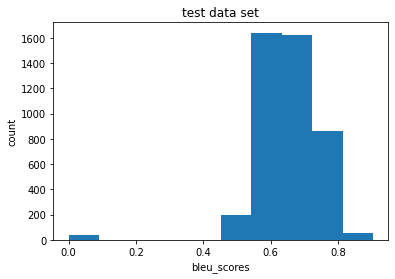

In [160]:
from matplotlib import pyplot as plt

plt.hist(bleu_scores)
plt.xlabel('bleu_scores')
plt.ylabel('count')
plt.title('test data set')
plt.show

In [112]:
correct = correct.flatten()
# 머릿글자
start_id = correct[0]
correct = correct[1:]
guess = model.generate(question, start_id, len(correct))

# 문자열로 변환
question = ''.join([inp_lang.index_word[c] for c in question.flatten() if c!=0 ])
correct = ' '.join([targ_lang.index_word[c] for c in correct.flatten() if c!=0 ])
guess = ' '.join([targ_lang.index_word[c] for c in guess[2]  if c!=0])

print("question : ",question)
print("correct : ",correct)
print("guess : ", guess)

[[[ 6.53957874e-02  1.30839095e-01  9.60885137e-02 ...  5.35155609e-02
    5.14495522e-02  7.80573264e-02]
  [-1.22605279e-01  3.59594375e-02  1.11628957e-01 ...  2.33500898e-01
   -1.88850656e-01  4.22665440e-02]
  [-5.98808145e-03  2.82422802e-03  7.78547376e-02 ... -2.74982583e-02
   -4.83200438e-02  2.99593946e-03]
  ...
  [-1.43842146e-04 -4.83187567e-03 -6.22243956e-02 ... -8.54601711e-03
   -1.52210090e-02 -8.37332979e-02]
  [-1.33896770e-04 -4.90656635e-03 -6.23020567e-02 ... -8.36055540e-03
   -1.01581365e-02 -8.32081139e-02]
  [-1.23741265e-04 -4.98652505e-03 -6.23782501e-02 ... -8.17198679e-03
   -5.05228294e-03 -8.26702192e-02]]]
[[-0.00012374 -0.00498653 -0.06237825 ... -0.00817199 -0.00505228
  -0.08267022]]
19
197
6
522
77
19
26
2031
164
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
question :  <start>她18岁的时候来到东京。<end>
correct :  she came to tokyo at the age of . <end>
guess :  she came to tokyo when she was eighteen years . <end>


In [115]:
correct = correct.flatten()

In [116]:
for c in correct:
  if c != 0:
    print(targ_lang.index_word[c])

<start>
she
came
to
tokyo
at
the
age
of
.
<end>


In [89]:
start_id = correct[0]
correct = correct[1:]
print(len(correct))
guess = model.generate(question, start_id, len(correct))

29
[[[ 6.53957874e-02  1.30839095e-01  9.60885137e-02 ...  5.35155609e-02
    5.14495522e-02  7.80573264e-02]
  [-9.98957176e-03 -3.85800637e-02  2.33267583e-02 ...  1.15557276e-02
    9.74552035e-02 -5.74479401e-02]
  [-4.50228117e-02  2.67465740e-01  1.05048969e-01 ...  1.27252221e-01
   -3.99406672e-01  2.58290142e-01]
  ...
  [ 3.08666786e-04 -1.10544795e-02 -6.32498190e-02 ... -2.76476424e-03
    1.07092105e-01 -5.45826070e-02]
  [ 3.08264163e-04 -1.10457046e-02 -6.32067993e-02 ... -2.76421546e-03
    1.07085139e-01 -5.45578487e-02]
  [ 3.07894778e-04 -1.10374568e-02 -6.31677955e-02 ... -2.76381103e-03
    1.07078962e-01 -5.45358174e-02]]]
[[ 0.00030789 -0.01103746 -0.0631678  ... -0.00276381  0.10707896
  -0.05453582]]
28
66
65
8
149
17
415
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [70]:
guess[2]

[128, 33, 121, 602, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [59]:
guess[0].shape

(1, 46, 1024)

In [60]:
guess[1].shape

(1, 1024)

In [61]:
print(guess[0][:,-1])

[[ 0.00029977 -0.01100156 -0.06296348 ... -0.00275935  0.10615145
  -0.05452206]]


In [62]:
np.array([[[1,2,3],[4,5,6]]])[:,-1]

array([[4, 5, 6]])

In [63]:
guess[0][:,-1].shape

(1, 1024)

In [84]:
for c in question.flatten():
  if c!= 0:
    print(inp_lang.index_word[c])

<start>
我
们
喝
了
很
多
。
<end>


In [114]:
for c in correct:
  if c != 0:
    print(targ_lang.index_word[c])

ValueError: ignored

In [90]:
for c in guess[2]:
  if c != 0:
    print(targ_lang.index_word[c])

we
ve
had
a
lot
of
fun
.
<end>


In [47]:
guess = ''.join([id_to_char[int(c)] for c in guess])

NameError: ignored

In [167]:
question[:,:]

array([[  1,   7,  75, 268, 169, 125, 115,  42,   5,   3, 202,  12, 151,
        244,  60,  14, 147, 134, 762,  84,   6,   3,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [79]:
model.generate(question, start_id, len(correct))

[[-0.00020168 -0.00291531 -0.05971526 ... -0.01114014 -0.07140171
  -0.09442762]]
[[-0.00020168 -0.00291531 -0.05971526 ... -0.01114014 -0.07140171
  -0.09442762]]


[]

In [62]:
 def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))
            print(x)

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [ ]:
correct = correct.flatten()
# 머릿글자
start_id = correct[0]
correct = correct[1:]
guess = model.generate(question, start_id, len(correct))

# 문자열로 변환
question = ''.join([inp_lang.index_word[c] for c in question.flatten() if c!=0 ])
correct = ''.join([targ_lang.index_word[c] for c in correct.flatten() if c!=0 ])
guess = ''.join([targ_lang.index_word[c] for c in guess  if c!=0])

print("question : ",question)
print("correct : ",correct)
print("guess : ", guess)

In [118]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        # print(enc_hs)
        h = enc_hs[:, -1]
        # print(h)
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            # print(sample_id)
            sampled.append(sample_id)

        return enc_hs,h,sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, tar_vocab_size ,wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        args2 = tar_vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args2)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [ ]:
def save_params(self, file_name=None):
    if file_name is None:
        file_name = self.__class__.__name__ + '.pkl'

    params = [p.astype(np.float16) for p in self.params]
    if GPU:
        params = [to_cpu(p) for p in params]

    with open('./drive/My Drive/Colab Notebooks/training_checkpoints/cmn-eng/'+ file_name, 'wb') as f:
        pickle.dump(params, f)

In [ ]:
def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0

In [ ]:
str(2)+'.pkl'

'2.pkl'